In [1]:
import math
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import locale
locale.setlocale(locale.LC_ALL, 'German')

%matplotlib notebook

In [2]:
principal =  396846 
interest_rates = np.linspace(1.5, 3.5, 21, True)
term_length = np.arange(20, 31)

In [3]:
def calculate_pmt(interest, years, principal):
    """ 
        function returning the monthly payments to be made on a loan.
        
        interest:   provide the rate given to you by the bank   e.g. 2.1
        years:      provide the year-length of the mortgage     e.g. 30
        principal:  the current value of the asset              e.g. 250000
    
    """
    
    r = interest / 100 / 12  # monthly interest
    n = years * 12           # period in months
    P = principal
    
    numerator = r * (1 + r) ** n
    denominator = (1 + r) ** n - 1
    fraction = numerator / denominator
    
    M = P * fraction
    
    return M

In [4]:
def calculate_interest_income(yearly_ror, years, yearly_added_amount): 
    """ calculated the interest generated by an investment portfolio, assuming an amount is added yearly """
    fv = 0
    for i in range(years+1):
        fv *= 1 + yearly_ror/100
        if i != years: fv += yearly_added_amount
                
    return fv - (years * yearly_added_amount)

Text(0.5,0,'Monthly Payments (€)')

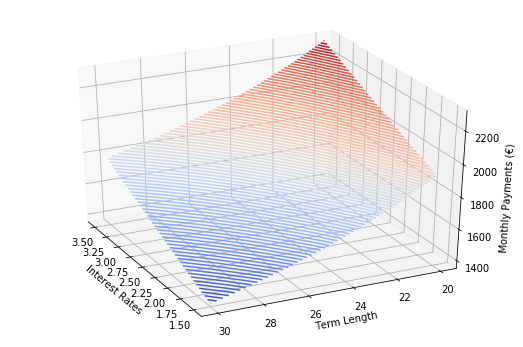

In [5]:
fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')

x = interest_rates
y = term_length
X, Y = np.meshgrid(x, y)
Z = calculate_pmt(X, Y, principal)

ax.contour3D(X, Y, Z, 100, cmap=cm.coolwarm)
ax.view_init(elev=32, azim=(154))

ax.set_xlabel('Interest Rates')
ax.set_ylabel('Term Length')
ax.set_zlabel('Monthly Payments (€)')

In [6]:
class Buyer:
    """
        Class containing information on the person buying the house
        Takes 3 arguments:
            1) disposable_income: integer - current after-tax income you can theoretically spend
            2) monthly_expenses:  integer - average money spent per month on groceries, water, gas, electricity, etc.
            3) buffer_budget:     integer - amount to be put aside in cash as a safety margin
            4) currency:          string  - the currency in which the asset is bought
            
        The mortgage will take disposable_income - (monthly_expenses + buffer_budget) as the budget ceiling.
    
    """

    def __init__(self, disposable_income, monthly_expenses, buffer_budget, currency):
        self.disposable_income = disposable_income
        self.monthly_expenses = monthly_expenses
        self.buffer_budget = buffer_budget
        self.currency = currency
        
    @property
    def spendable_money(self):
        return self.disposable_income - self.monthly_expenses - self.buffer_budget

In [7]:
class Mortgage(object):
    """
        Class containing information on the mortgage offer. 
        Takes 4 arguments:
            1) rate:       float   - interest %. input this in percentage terms. 
            2) years:      integer - term length in years. 
            3) principal:  integer - present value of the asset being bought
            4) Buyer:      object  - pass the Buyer class as an argument
            
        Attributes:
            rate, years, principal, Buyer,
            monthly_payments,
            total_mortgage_cost,
            total_interest_cost,
            investment_budget,
            required_appreciation_rate
        
        Methods:
            plot_asset_appreciation()
            summarize()
    """
    
    def __init__(self, rate, years, principal, Buyer):
        self.rate = rate
        self.years = years
        self.principal = principal
        self.Buyer = Buyer

    @property
    def rate(self):
        return self._rate
    @rate.setter
    def rate(self, value):
        if value < 0:
            raise ValueError("The nominal interest rate cannot be below 0!")
        self._rate = value
        
    @property
    def years(self):
        return self._years
    @years.setter
    def years(self, value):
        if value <= 0:
            raise ValueError("Provide a positive amount of years...")
        self._years = value
        
    @property
    def principal(self):
        return self._principal
    @principal.setter
    def principal(self, value):
        if value <= 0:
            raise ValueError("Can't borrow a negative amount of money...")
        self._principal = value
        
    @property
    def monthly_payments(self):
        return calculate_pmt(self.rate, self.years, self.principal)
    
    @property
    def total_mortgage_cost(self):
        """ Cummulative sum of monthly payments """
        return self.monthly_payments * (self.years*12)
    
    @property
    def total_interest_cost(self):       
        return self.total_mortgage_cost - self.principal
    
    @property
    def investment_budget(self):
        """ Monthly investment budget that is left over after mortgage payments. 
            Takes into account the Buyer's pre-defined disposable income, expenses, and buffer budget """
        
        return self.Buyer.spendable_money - self.monthly_payments
    
    @property
    def required_appreciation_rate(self):
        """ Calculates how much your asset needs to appreciate in order to break even, 
            vis-a-vis to the mortgage's interest costs """
        
        fv = (self.principal + self.total_interest_cost) 
        pv = self.principal
        exponent = 1 / self.years
        return ((fv/pv)**exponent - 1)
    
    def plot_asset_appreciation(self, appreciation_rate=None):
        """ plots the asset value over time, compounded by a yearly appreciation rate
            if the latter is not supplied, the self.required_appreciation_rate is used as default """
        
        appreciation_rate = appreciation_rate/100 if appreciation_rate is not None else self.required_appreciation_rate
        pv = self.principal
        fv = self.total_mortgage_cost
        
        x = np.arange(self.years+1)
        y1 = self.principal * (1 + appreciation_rate) ** x
        t = round(math.log(fv/pv, 1 + appreciation_rate), 1)
        y2 = [fv for year in x]
        
        plt.figure(figsize=(7, 4))
        plt.plot(x, y1, label="asset value")
        plt.plot(x, y2, label="total mortgage cost")
        plt.scatter(t, fv, s=100, c="green", zorder=3, label="break-even point")
        plt.legend()
        print("At an interest rate of {}%, and an appreciation rate of {:.2f}%, the break even point occurs at year {}\n"\
              .format(self.rate, appreciation_rate*100, t))
        
    def summarize(self):
        print("This mortgage borrows {} {:,} at {}% over {} years." \
              .format(self.Buyer.currency,
                      self.principal,
                      self.rate, 
                      self.years))
        print("Monthly payments are {} {:,.2f}, totalling to mortgage interest costs of {} {:,.2f}" \
              .format(self.Buyer.currency,
                      self.monthly_payments,
                      self.Buyer.currency,
                      self.total_interest_cost))
        print("The yearly appreciation rate of the asset required to make up for the interest cost is {:,.3f}%" \
              .format(100 * self.required_appreciation_rate))
        
    def invest_remainder(self, ror):
        print("The income left over to invest is {} {:,.2f}".format(self.Buyer.currency, self.investment_budget))
        print("This leftover budget, if invested yearly at a rate of return of {}%,".format(ror))
        print("will generate interests totalling up to: {} {:,.2f}" \
              .format(self.Buyer.currency,
                      calculate_interest_income(yearly_ror=ror,
                                                years=self.years,
                                                yearly_added_amount=self.investment_budget * 12)))

In [8]:
Jeff = Buyer(disposable_income=3500, monthly_expenses=700, buffer_budget=200, currency="€")
House_1 = Mortgage(rate=2.2, years=30, principal=460000, Buyer=Jeff)

House_1.summarize()
print("")
House_1.invest_remainder(ror=5)

This mortgage borrows € 460,000 at 2.2% over 30 years.
Monthly payments are € 1,746.62, totalling to mortgage interest costs of € 168,784.59
The yearly appreciation rate of the asset required to make up for the interest cost is 1.047%

The income left over to invest is € 853.38
This leftover budget, if invested yearly at a rate of return of 5%,
will generate interests totalling up to: € 407,170.91


At an interest rate of 2.2%, and an appreciation rate of 2.50%, the break even point occurs at year 12.7



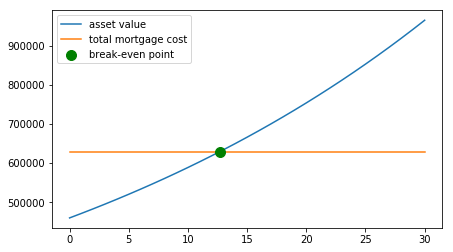

In [9]:
House_1.plot_asset_appreciation(2.5)